# Wumpus World Unity Environment Log Analysis

This notebook contains our analysis of performance logs from different AI agent implementations in the Wumpus World Unity environment.

We compare execution times and behavioral patterns across multiple scenarios with varying complexity.

## Context

The analysis focuses on different AI types including:
- Basic Rule-based agents
- Finite State Machine agents
- Behavior Tree agents
- Prolog agents
- Prolog Meta Interpreter agents

Each scenario uses different configurations of world size, number of agents, and dangers (pits and Wumpus) distribution.

### Common Parameters Across All Configurations

| Parameter | Value |
|:----------|:------|
| **randomSeed** | 1 |
| **nbGold** | 1 |
| **nbAgent** | [1, 5, 10] |
| **aiType** | [Basic, FiniteStateMachine, BehaviorTree, Prolog, PrologMetaInterpreter] |
| **personalities** | [Cupid-Brave, Ascetic-Coward, Cupid-Coward] |

The decision logic is the same across all AI implementations, leading to the same exploration patterns.

There are very small differences in step counts due to the way the AI types are implemented and how the actions taken are collected.

### Grid-Specific Configurations

| Grid Size | Number of Cells | Number of Pits & Wumpus |
|:---------:|:---------------:|:-----------------------:|
| 10x10     | 100             | 3                       |
| 15x15     | 225             | 7                       |
| 20x20     | 400             | 12                      |
| 25x25     | 625             | 19                      |
| 30x30     | 900             | 27                      |
| 50x50     | 2500            | 75                      |
| 100x100   | 10000           | 300                     |

We have 7 grid sizes, 3 personality sets, 5 AI types, and 3 agent numbers.

So, there are `7*3*5*3=315` configurations.

#### Prolog Meta Interpreter Limitations
We have 45 files for 10x10, 15x15, 20x20, and 25x25 grids, but only 36 files for 30x30, 50x50, and 100x100 grids because the Prolog Meta Interpreter agent algorithm was too resource-intensive, causing Unity to crash.

Therefore, to ensure fair comparison in the analysis, we will only consider the first 4 grid sizes (10x10, 15x15, 20x20, and 25x25).

### Data Collection

Files are stored in the `data` directory (same as this file). The data is organized in subdirectories based on the grid size:
- 10x10
- 15x15
- 20x20
- 25x25
- 30x30
- 50x50
- 100x100

Each json file follows the naming convention:
```
<grid_size>_<nb_agents>_<nb_wumpus_pits>_<nb_gold>_<personality1>_<personality2>_<ai_type>.json
```

For example, for a 10x10 grid with 1 agent, 3 wumpus/pits, and 1 gold, using the Cupid and Coward personalities with a Basic AI type, the file would be in folder `10x10` under the name:
```
10x10/10x10-1a-3wp-1g-Cupid-Coward-Basic.json
```

### Data Structure

Each JSON file contains an array with two objects:

1. **Game Configuration and Performance Data**:
    - `randomSeed`: The seed used for randomization
    - `gridMin` & `gridMax`: Boundaries of the grid
    - `tileSize`: Size of each tile
    - `nbPit`, `nbWumpus`, `nbGold`: Number of pits, wumpuses, and gold
    - `nbAgent`: Number of agents
    - `aiType`: Type of AI used (Basic, Prolog, BehaviorTree, etc.)
    - `personalities`: Array of personality type IDs
    - `isGameOver`: Whether the game has ended
    - `isModeAuto`: Whether the game is running in automatic mode
    - `turnDuration`: Array of turn durations in milliseconds

2. **Agent Behavior Data**:
    - `agent`: Agent identifier
    - `actions`: Array of actions taken by the agent
    - `positions`: Array of position objects, with x,y coordinates for each turn

See [10x10/10x10-1a-3wp-1g-Cupid-Coward-Basic.json](10x10/10x10-1a-3wp-1g-Cupid-Coward-Basic.json) for an example of the data structure.

## 1. Performance Analysis Overview

This section focuses on analyzing the performance of different AI agent implementations within the Wumpus World environment. We analyze JSON log files from four grid sizes (10x10, 15x15, 20x20, 25x25) to establish comprehensive performance metrics.

Key metrics analyzed in this section:
- **Turn Duration**: The average time each agent takes to decide and execute an action, measured in milliseconds
- **Total Execution Time**: The cumulative time for the entire execution of the game, from start to finish
- **Steps Taken**: The total number of movements made by agents

**Important Note on Multi-Agent Metrics**: For scenarios with multiple agents (5 or 10 agents), the metrics (steps, mean turn duration, and total execution time) represent the cumulative values across all agents to reflect the total computational cost and work performed by all agents combined. This adjustment provides a fair comparison across different agent counts by measuring the total system resources consumed.

The analysis compares these metrics across:
1. Different AI types (Basic, Finite State Machine, Behavior Tree, Prolog, Prolog Meta Interpreter)
2. Varying numbers of agents (1, 5, 10)
3. Different personality combinations (Cupid-Brave, Ascetic-Coward, Cupid-Coward)
4. Four grid sizes with increasing complexity

The visualizations reveal performance patterns and trade-offs between different agent implementations, with particular focus on computational efficiency, scalability, and exploration strategies.

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
import seaborn as sns
from glob import glob
from matplotlib.ticker import ScalarFormatter

# Enhanced plotting configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Custom color palette for AI types
ai_colors = {
    'Basic': '#1f77b4',  # Bright Blue
    'FiniteStateMachine': '#ff7f0e',  # Bright Orange
    'BehaviorTree': '#2ca02c',  # Bright Green
    'Prolog': '#d62728',  # Bright Red
    'PrologMetaInterpreter': '#9467bd'  # Bright Purple
}

# Custom colors for personalities
personality_colors = {
    'Cupid-Brave': '#e74c3c',  # Bright Red
    'Ascetic-Coward': '#3498db',  # Bright Blue
    'Cupid-Coward': '#f39c12'  # Bright Orange
}

# Global plotting parameters
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'figure.titlesize': 18,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3
})


# Keep the existing functions
def load_json_data(file_path):
    """Load data from a JSON file."""
    with open(file_path, "r") as f:
        return json.load(f)


def get_turn_duration_stats(data):
    """Extract turn duration statistics from game data."""
    turn_durations = data[0]["turnDuration"]
    return {
        "mean": np.mean(turn_durations),
        "median": np.median(turn_durations),
        "min": np.min(turn_durations),
        "max": np.max(turn_durations),
        "std": np.std(turn_durations),
        "total": np.sum(turn_durations),
        "count": len(turn_durations),
    }


def analyze_agent_actions(data):
    """Analyze the frequency of different actions taken by agent."""
    actions = data[1]["actions"]
    action_counts = {}
    for action in actions:
        if action in action_counts:
            action_counts[action] += 1
        else:
            action_counts[action] = 1
    return action_counts


# Define function to calculate movement efficiency
def calculate_movement_efficiency(positions):
    total_steps = len(positions) - 1
    unique_positions = len(set((pos["x"], pos["y"]) for pos in positions))
    return {
        "total_steps": total_steps,
        "unique_positions": unique_positions
    }


# Function to parse file name to extract metadata
def parse_filename(filename):
    # Using regex to extract parts from filename
    pattern = r"(\d+)x\d+-(\d+)a-\d+wp-\d+g-(\w+)-(\w+)-(\w+).json"
    match = re.search(pattern, filename)
    if match:
        grid_size = match.group(1)
        num_agents = match.group(2)
        trait1 = match.group(3)
        trait2 = match.group(4)
        ai_type = match.group(5)
        return {
            "grid_size": int(grid_size),
            "num_cells": int(grid_size) ** 2,  # Add number of cells calculation
            "num_agents": int(num_agents),
            "trait1": trait1,
            "trait2": trait2,
            "ai_type": ai_type,
            "personality": f"{trait1}-{trait2}",
        }
    return None


# Load data from all grid sizes
all_data = {}
metadata = []

# Process files from all grid sizes
for grid_size in [10, 15, 20, 25]:
    # Use glob to find all .json files in each grid size directory
    grid_file_paths = glob(f"{grid_size}x{grid_size}/*.json")
    
    # Sort the file paths for consistent processing
    grid_file_paths.sort()
    
    print(f"Found {len(grid_file_paths)} files in {grid_size}x{grid_size} directory")
    
    # Process files and extract metadata
    for file_path in grid_file_paths:
        meta = parse_filename(file_path)
        if meta:
            data = load_json_data(file_path)

            # Collect stats
            turn_stats = get_turn_duration_stats(data)
            action_counts = analyze_agent_actions(data)
            movement_efficiency = calculate_movement_efficiency(data[1]["positions"])

            # Store all info
            file_key = (
                f"{meta['grid_size']}x{meta['grid_size']}-{meta['num_agents']}a-{meta['trait1']}-{meta['trait2']}-{meta['ai_type']}"
            )
            all_data[file_key] = {
                "data": data,
                "meta": meta,
                "stats": {
                    "turn_stats": turn_stats,
                    "action_counts": action_counts,
                    "movement_efficiency": movement_efficiency,
                },
            }

            # Add stats to metadata for DataFrame
            # For multiple agents, multiply metrics by number of agents
            num_agents = meta["num_agents"]
            
            meta_entry = {
                **meta,
                "mean_turn": turn_stats["mean"] * num_agents,  # Multiply by number of agents
                "median_turn": turn_stats["median"] * num_agents,  # Multiply by number of agents
                "max_turn": turn_stats["max"] * num_agents,  # Multiply by number of agents
                "total_time": turn_stats["total"] * num_agents,  # Multiply by number of agents
                "steps": movement_efficiency["total_steps"] * num_agents,  # Multiply by number of agents
                "actions": len(action_counts)
            }
            metadata.append(meta_entry)

# Create DataFrame for easier analysis
df = pd.DataFrame(metadata)
print(f"Processed a total of {len(metadata)} files across all grid sizes")
print(f"Grid sizes in dataset (nb of cells): {[int(cells) for cells in sorted(df['num_cells'].unique())]}")
print(f"AI types in dataset: {sorted(df['ai_type'].unique())}")

print(f"Personalities in dataset: {sorted(df['personality'].unique())}")

Found 45 files in 10x10 directory
Found 45 files in 15x15 directory
Found 45 files in 20x20 directory
Found 45 files in 25x25 directory
Processed a total of 180 files across all grid sizes
Grid sizes in dataset (nb of cells): [100, 225, 400, 625]
AI types in dataset: ['Basic', 'BehaviorTree', 'FiniteStateMachine', 'Prolog', 'PrologMetaInterpreter']
Personalities in dataset: ['Ascetic-Coward', 'Cupid-Brave', 'Cupid-Coward']


## 2. Mean Turn Duration by Grid Size and AI Type

This boxplot compares the distribution of average turn duration times across different AI implementations and grid sizes. The analysis reveals significant performance differences:

**Key Observations:**
- **Basic, FSM, and BehaviorTree** agents maintain consistently low turn durations (~1 ms) across all grid sizes
- **Prolog** agents show moderate turn durations (~10 ms) with minimal variation across grid complexity
- **PrologMetaInterpreter** exhibits the highest turn durations (~128 ms), demonstrating the computational overhead of meta-interpretation
- Turn duration performance remains relatively stable across different grid sizes for all AI types
- The performance hierarchy clearly distinguishes procedural approaches from logic-based implementations

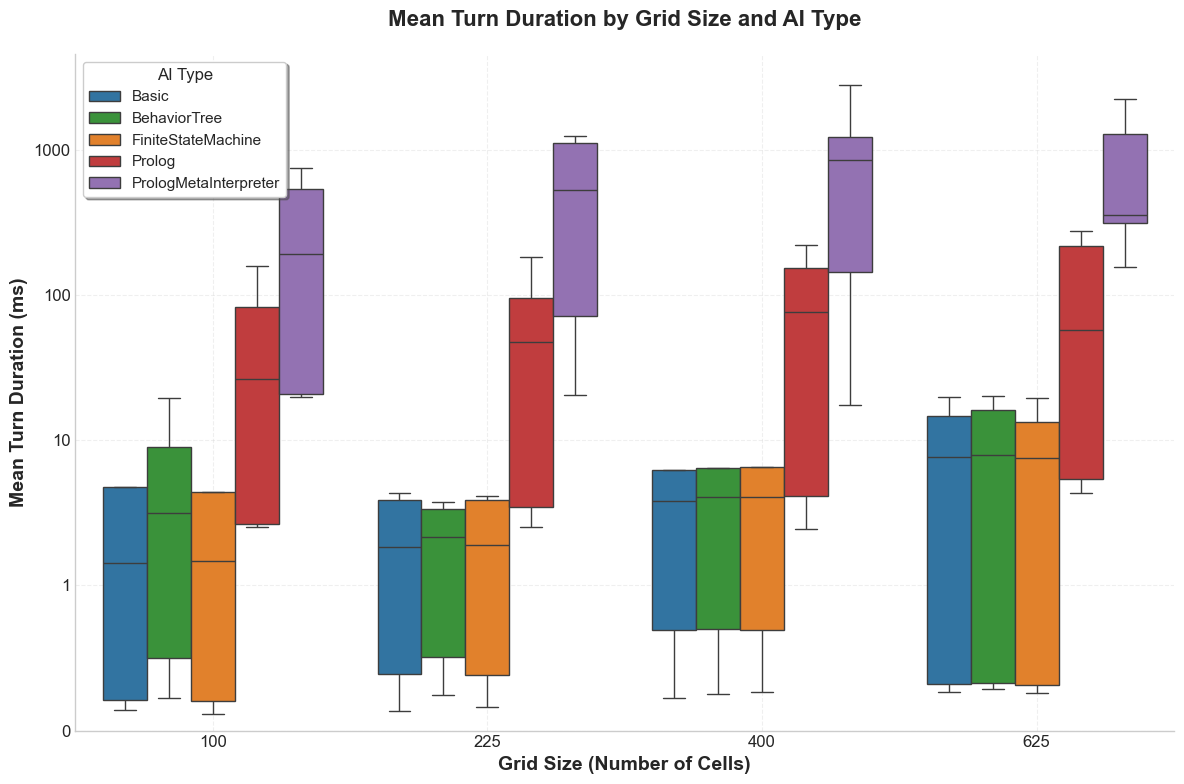

In [2]:
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x="num_cells", y="mean_turn", hue="ai_type", data=df, 
                 showfliers=False, palette=ai_colors)
plt.title("Mean Turn Duration by Grid Size and AI Type", 
          fontweight='bold', pad=20)
plt.yscale("log")
plt.xlabel("Grid Size (Number of Cells)", fontweight='bold')
plt.ylabel("Mean Turn Duration (ms)", fontweight='bold')

# Customize legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='AI Type', title_fontsize=12, 
          loc='upper left', frameon=True, fancybox=True, shadow=True)

# Format y-axis to show actual values on log scale
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_ylim(bottom=0.1)

# Add grid
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('./figures/grid_size_ai_type_mean_turn.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 3. Total Execution Time by Grid Size and AI Type

This bar chart illustrates the cumulative processing time required by different AI implementations across various grid sizes. The analysis reveals dramatic scalability differences:

**Key Observations:**
- **Basic, FSM, and BehaviorTree** agents maintain sub-second execution times across all grid sizes, demonstrating excellent scalability
- **Prolog** agents show moderate increases in execution time, ranging from ~270 ms to ~2.6 seconds as grid size increases
- **PrologMetaInterpreter** exhibits exponential scaling issues, jumping from ~1.8 seconds on 10x10 grids to over 106 seconds on 25x25 grids
- The performance gap between procedural and logic-based AIs grows dramatically with grid complexity
- Total execution time scales super-linearly with grid size for all AI types, but logic-based approaches are disproportionately affected

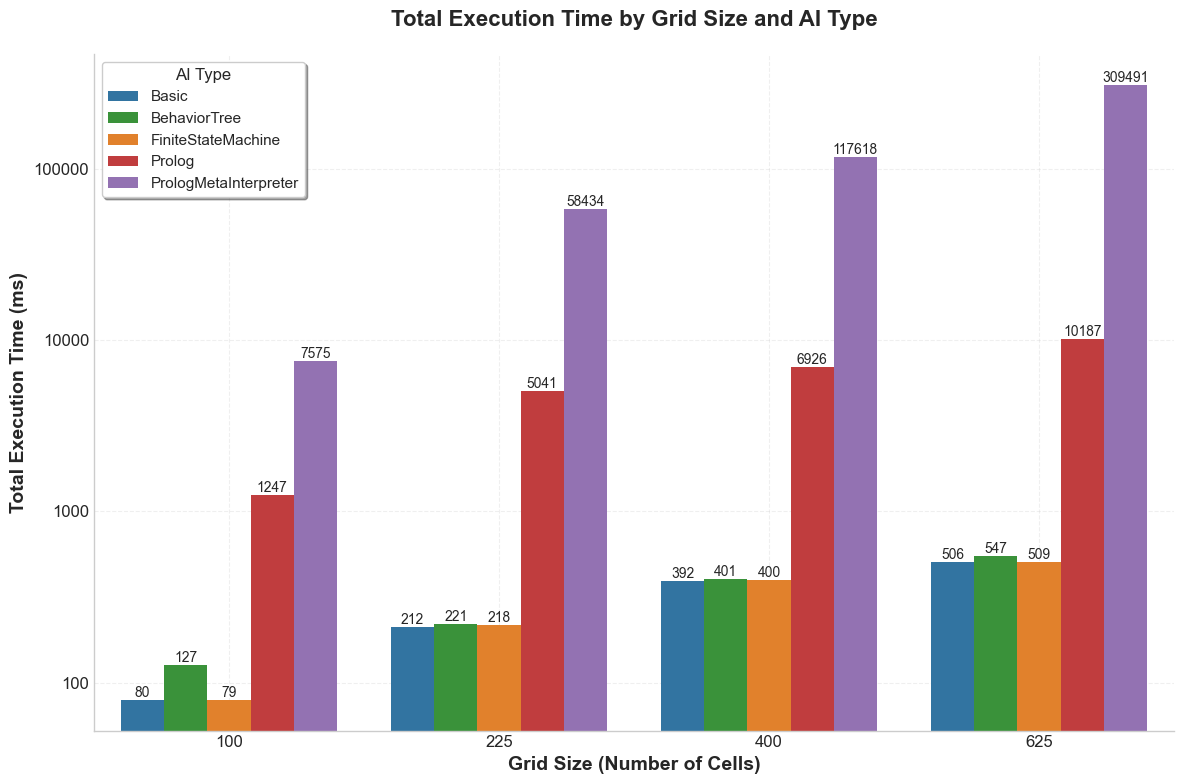

In [3]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(x="num_cells", y="total_time", hue="ai_type", data=df, 
                 errorbar=None, palette=ai_colors)
plt.title("Total Execution Time by Grid Size and AI Type", 
          fontweight='bold', pad=20)
plt.yscale("log")
plt.xlabel("Grid Size (Number of Cells)", fontweight='bold')
plt.ylabel("Total Execution Time (ms)", fontweight='bold')

# Customize legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='AI Type', title_fontsize=12, 
          loc='upper left', frameon=True, fancybox=True, shadow=True)

# Format y-axis to show actual values on log scale
ax.yaxis.set_major_formatter(ScalarFormatter())

# Add grid
ax.grid(True, alpha=0.3, linestyle='--')

# Add value labels on bars for better readability
for container in ax.containers:
    ax.bar_label(container, fmt="%.0f", fontsize=10, rotation=0)

plt.tight_layout()
plt.savefig('./figures/grid_size_ai_type_total_time.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 4. Mean Steps by Grid Size and AI Type

This bar chart displays the average number of steps taken by agents across different grid sizes and AI implementations. The analysis confirms uniform exploration behavior across AI types:

**Key Observations:**
- **All AI types** take virtually identical numbers of steps, confirming that the same decision logic is implemented across different AI architectures
- **Grid size correlation**: Steps scale almost linearly with grid area (62 steps for 100 cells → 365 steps for 625 cells)
- **Efficiency indicator**: The near-identical step counts validate that performance differences observed in previous charts are purely computational, not behavioral
- **Exploration consistency**: Minor variations (±1-2 steps) are due to implementation differences in action collection rather than strategic differences
- **Scalability validation**: The linear relationship between grid size and required steps provides a baseline for evaluating computational efficiency

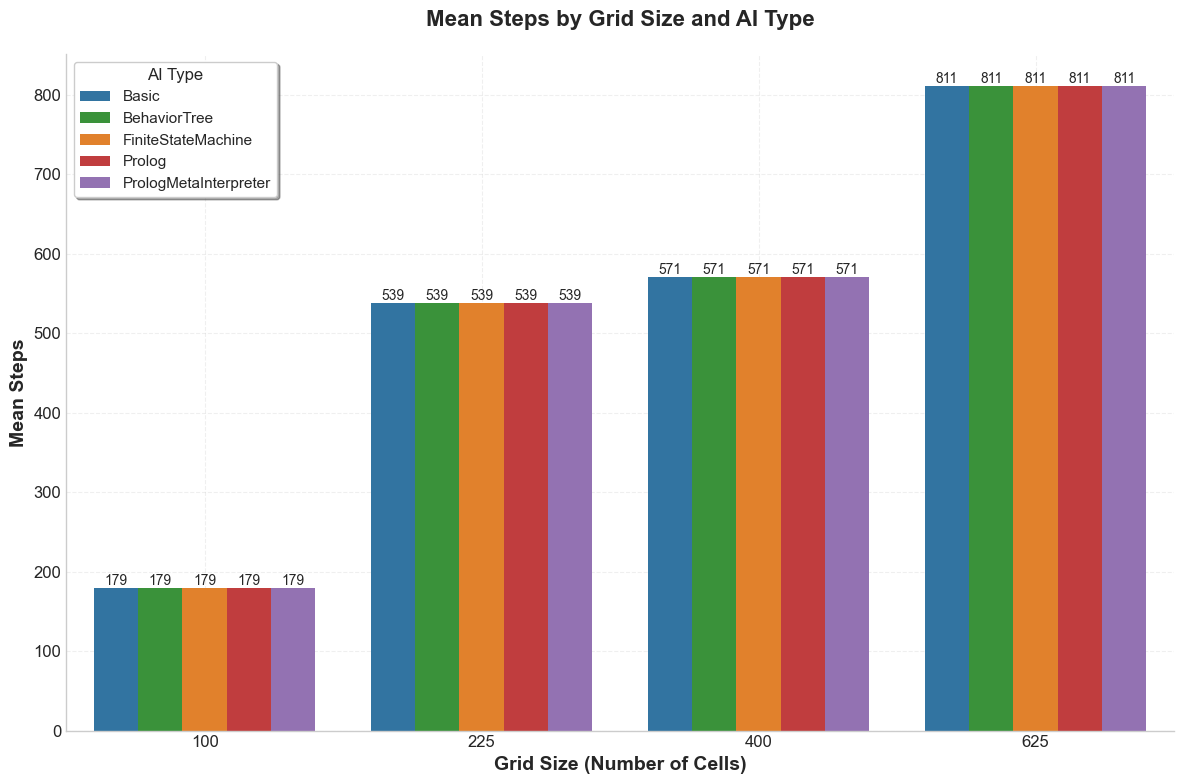

In [4]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(x="num_cells", y="steps", hue="ai_type", data=df, 
                 errorbar=None, palette=ai_colors)
plt.title("Mean Steps by Grid Size and AI Type", 
          fontweight='bold', pad=20)
plt.xlabel("Grid Size (Number of Cells)", fontweight='bold')
plt.ylabel("Mean Steps", fontweight='bold')

# Customize legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='AI Type', title_fontsize=12, 
          loc='upper left', frameon=True, fancybox=True, shadow=True)

# Add grid
ax.grid(True, alpha=0.3, linestyle='--')

# Add value labels on bars for better readability
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', fontsize=10, rotation=0)

plt.tight_layout()
plt.savefig('./figures/grid_size_ai_type_steps.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 5. Mean Turn Duration by Agent Count and AI Type

This boxplot examines how the number of agents affects average turn duration across different AI implementations.

**Note**: The turn duration values shown represent the cumulative computational cost across all agents to reflect total system load.

**Key Observations:**
- **Total computational cost**: Mean turn duration increases with agent count due to multiple agents working simultaneously
- **Consistent AI hierarchy**: PrologMetaInterpreter remains the slowest across all agent counts, while Basic/FSM/BehaviorTree maintain efficiency
- **Scalability patterns**: Logic-based AIs show more pronounced increases in total computational cost as more agents are deployed
- **Multi-agent scaling**: The increase in total computational time reflects the cumulative processing overhead of running multiple agents
- **Performance distribution**: Boxplot variance increases with agent count, suggesting more variable performance under multi-agent scenarios

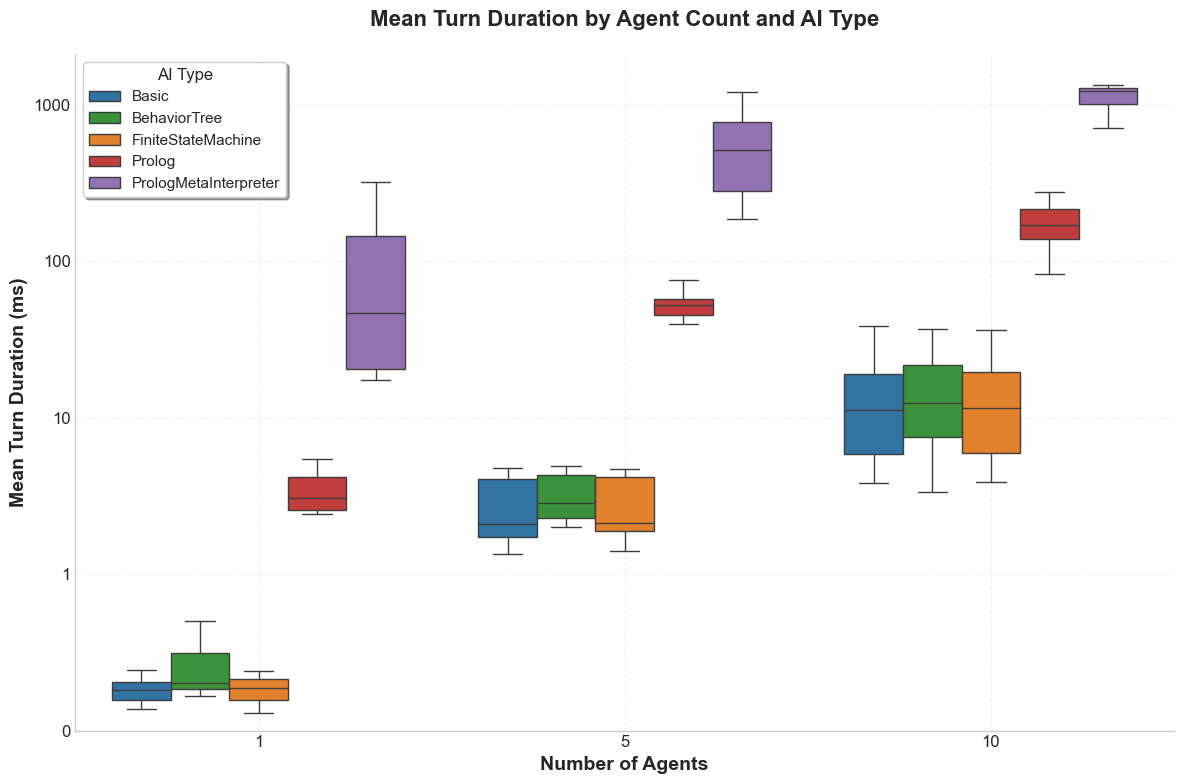

In [5]:
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x="num_agents", y="mean_turn", hue="ai_type", data=df, 
                 showfliers=False, palette=ai_colors)
plt.title("Mean Turn Duration by Agent Count and AI Type", 
          fontweight='bold', pad=20)
plt.yscale("log")
plt.xlabel("Number of Agents", fontweight='bold')
plt.ylabel("Mean Turn Duration (ms)", fontweight='bold')

# Customize legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='AI Type', title_fontsize=12, 
          loc='upper left', frameon=True, fancybox=True, shadow=True)

# Format y-axis to show actual values on log scale
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_ylim(bottom=0.1)

# Add grid
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('./figures/agent_count_ai_type_mean_turn.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 6. Total Execution Time by Agent Count and AI Type

This bar chart analyzes how the number of agents affects total execution time across different AI implementations.

**Note**: The execution time values shown are multiplied by the number of agents to represent the total computational work performed by all agents combined.

**Key Observations:**
- **Total computational work**: Total execution time increases with more agents as we measure the cumulative work performed by all agents
- **Per-agent efficiency**: While total computational cost increases, the work per individual agent decreases significantly
- **AI type consistency**: All AI types maintain their relative performance hierarchy across different agent counts
- **Resource scaling**: The increase in total computational time reflects the additional system resources required to run multiple agents
- **Efficiency trade-off**: Multiple agents complete the task faster but require more total computational resources

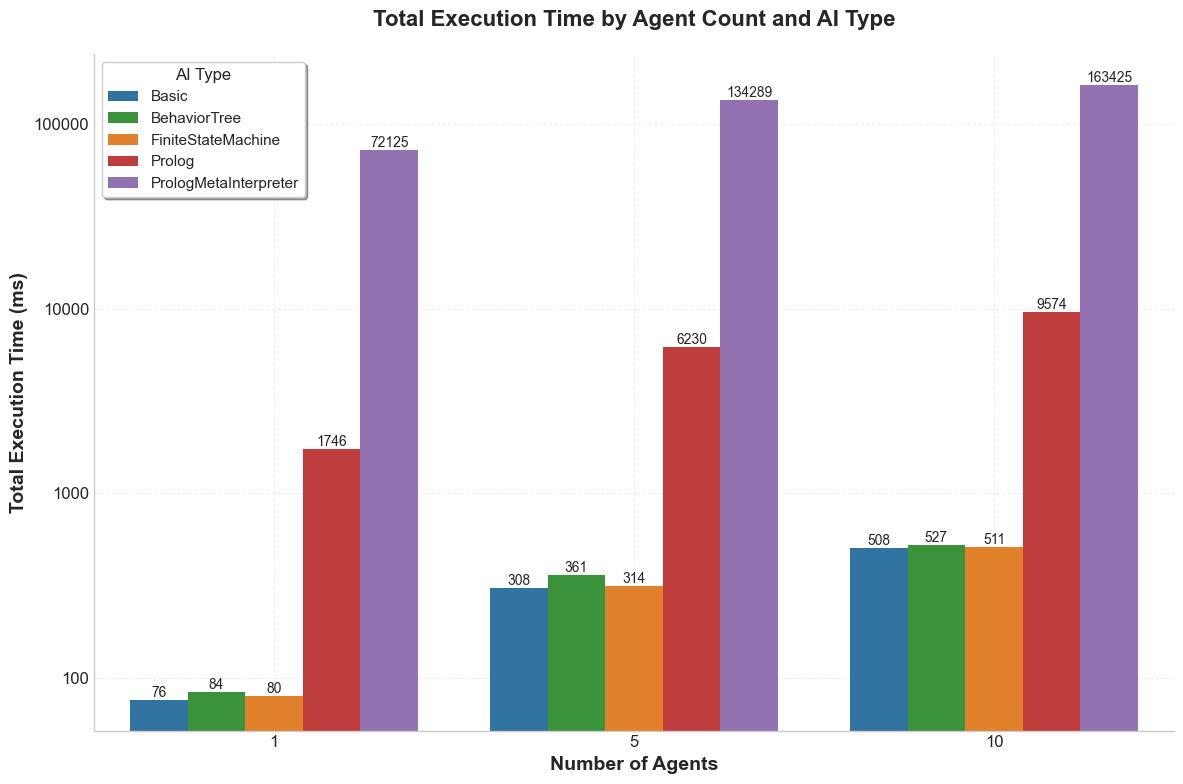

In [6]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(x="num_agents", y="total_time", hue="ai_type", data=df, 
                 errorbar=None, palette=ai_colors)
plt.title("Total Execution Time by Agent Count and AI Type", 
          fontweight='bold', pad=20)
plt.yscale("log")
plt.xlabel("Number of Agents", fontweight='bold')
plt.ylabel("Total Execution Time (ms)", fontweight='bold')

# Customize legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='AI Type', title_fontsize=12, 
          loc='upper left', frameon=True, fancybox=True, shadow=True)

# Format y-axis to show actual values on log scale
ax.yaxis.set_major_formatter(ScalarFormatter())

# Add grid
ax.grid(True, alpha=0.3, linestyle='--')

# Add value labels on bars for better readability
for container in ax.containers:
    ax.bar_label(container, fmt="%.0f", fontsize=10, rotation=0)

plt.tight_layout()
plt.savefig('./figures/agent_count_ai_type_total_time.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 7. Mean Steps by Agent Count and AI Type

This bar chart examines how the number of agents affects the total number of steps required for mission completion.

**Note**: The step values shown are multiplied by the number of agents to represent the total steps taken by all agents combined.

**Key Observations:**
- **Total step count**: Total steps increase with more agents as we measure the cumulative steps taken by all agents
- **Per-agent efficiency**: Individual agents take fewer steps when working in teams, but total system steps increase
- **Consistent behavior**: All AI types show identical step patterns, confirming uniform exploration logic implementation
- **Resource utilization**: The increase in total steps reflects the additional movement work performed by multiple agents
- **Exploration scaling**: Multiple agents cover the grid faster but require more total movement actions

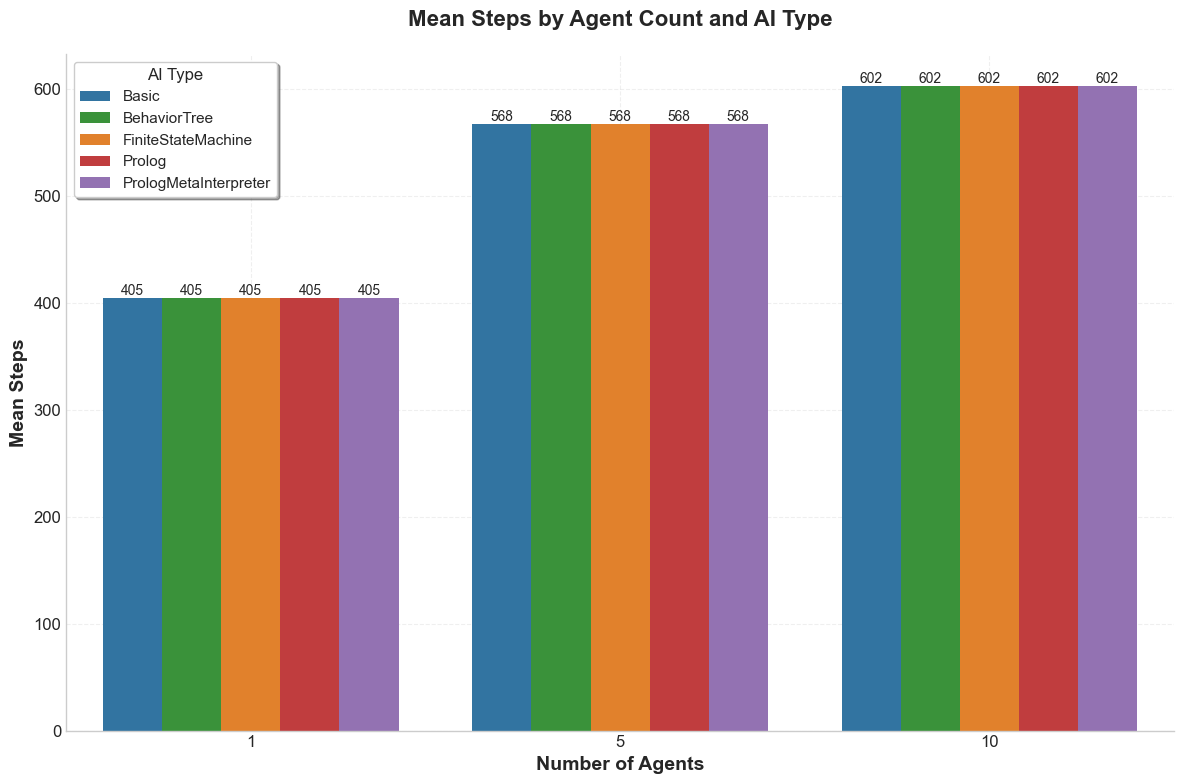

In [7]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(x="num_agents", y="steps", hue="ai_type", data=df, 
                 errorbar=None, palette=ai_colors)
plt.title("Mean Steps by Agent Count and AI Type", 
          fontweight='bold', pad=20)
plt.xlabel("Number of Agents", fontweight='bold')
plt.ylabel("Mean Steps", fontweight='bold')

# Customize legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='AI Type', title_fontsize=12, 
          loc='upper left', frameon=True, fancybox=True, shadow=True)

# Add grid
ax.grid(True, alpha=0.3, linestyle='--')

# Add value labels on bars for better readability
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', fontsize=10, rotation=0)

plt.tight_layout()
plt.savefig('./figures/agent_count_ai_type_steps.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 8. Mean Steps by AI Type and Personality

This boxplot analyzes the interaction between AI implementation and personality traits on exploration behavior. The analysis reveals significant personality-driven differences in exploration patterns:

**Key Observations:**
- **Personality hierarchy**: Ascetic-Coward agents take the most steps (~294), followed by Cupid-Coward (~177), then Cupid-Brave (~108)
- **Risk-taking behavior**: Brave personalities show more efficient exploration, taking fewer steps to complete missions
- **Coward patterns**: Coward personalities require more exploration steps, likely due to cautious avoidance behaviors
- **AI type consistency**: All AI implementations show identical step patterns within each personality type, confirming uniform decision logic
- **Behavioral variance**: The boxplot spread indicates some variability in exploration efficiency even within personality-AI combinations

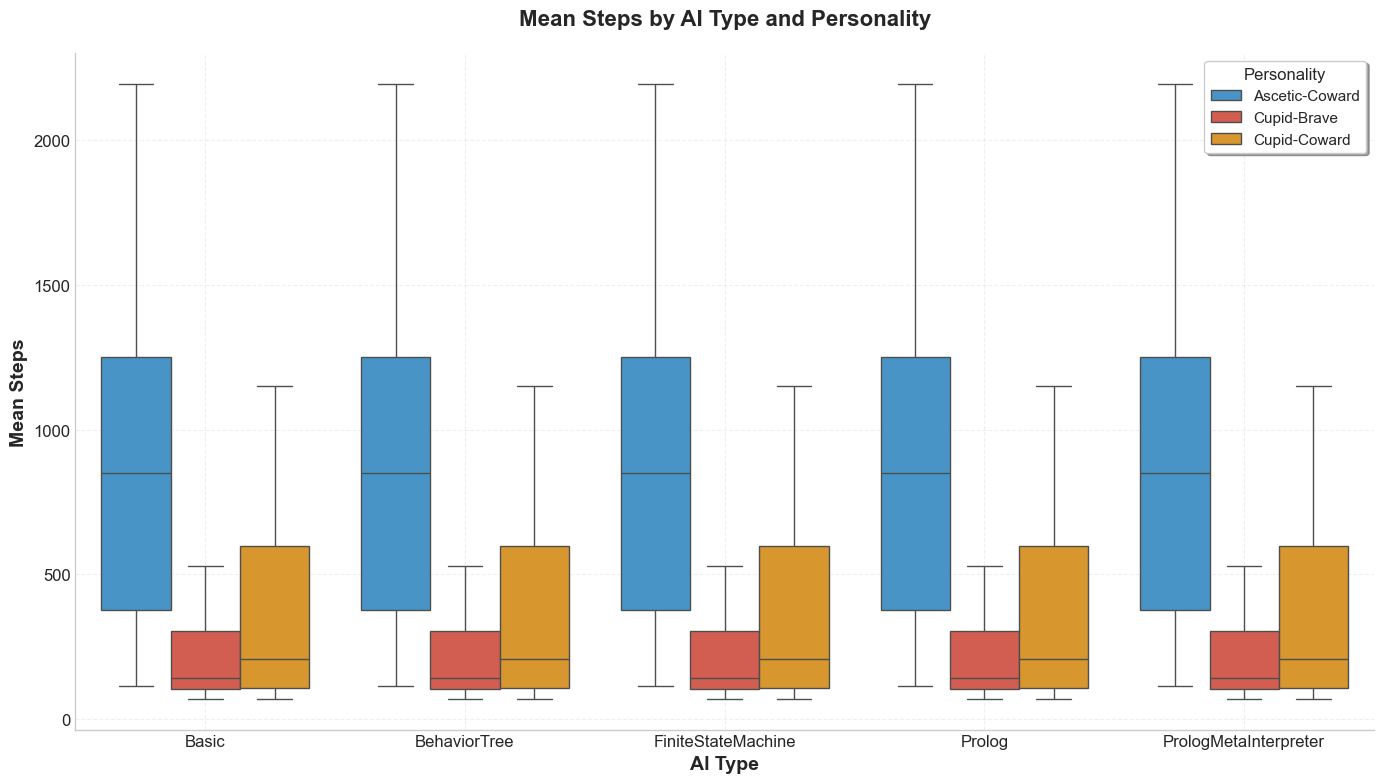

In [8]:
plt.figure(figsize=(14, 8))
ax = sns.boxplot(x="ai_type", y="steps", hue="personality", data=df, 
                 showfliers=False, palette=personality_colors)
plt.title("Mean Steps by AI Type and Personality", 
          fontweight='bold', pad=20)
plt.xlabel("AI Type", fontweight='bold')
plt.ylabel("Mean Steps", fontweight='bold')

# plt.xticks(rotation=45, ha='right')

# Customize legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Personality', title_fontsize=12, 
          loc='upper right', frameon=True, fancybox=True, shadow=True)

# Add grid
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('./figures/interaction_ai_personality.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 9. Mean Turn Duration by AI Type and Personality

This boxplot analyzes the interaction between AI implementation and personality traits on turn duration. The analysis reveals how personality affects computational performance across different AI architectures:

**Key Observations:**
- **AI type hierarchy maintained**: PrologMetaInterpreter remains the slowest across all personalities, while Basic/FSM/BehaviorTree maintain efficiency
- **Personality impact on performance**: Different personalities may show slight variations in decision time due to different exploration patterns
- **Computational consistency**: The relative performance differences between AI types remain consistent regardless of personality traits
- **Decision complexity**: More cautious personalities (Coward types) may require slightly more computation time for risk assessment
- **Performance distribution**: Boxplot variance shows how personality traits interact with AI computational overhead


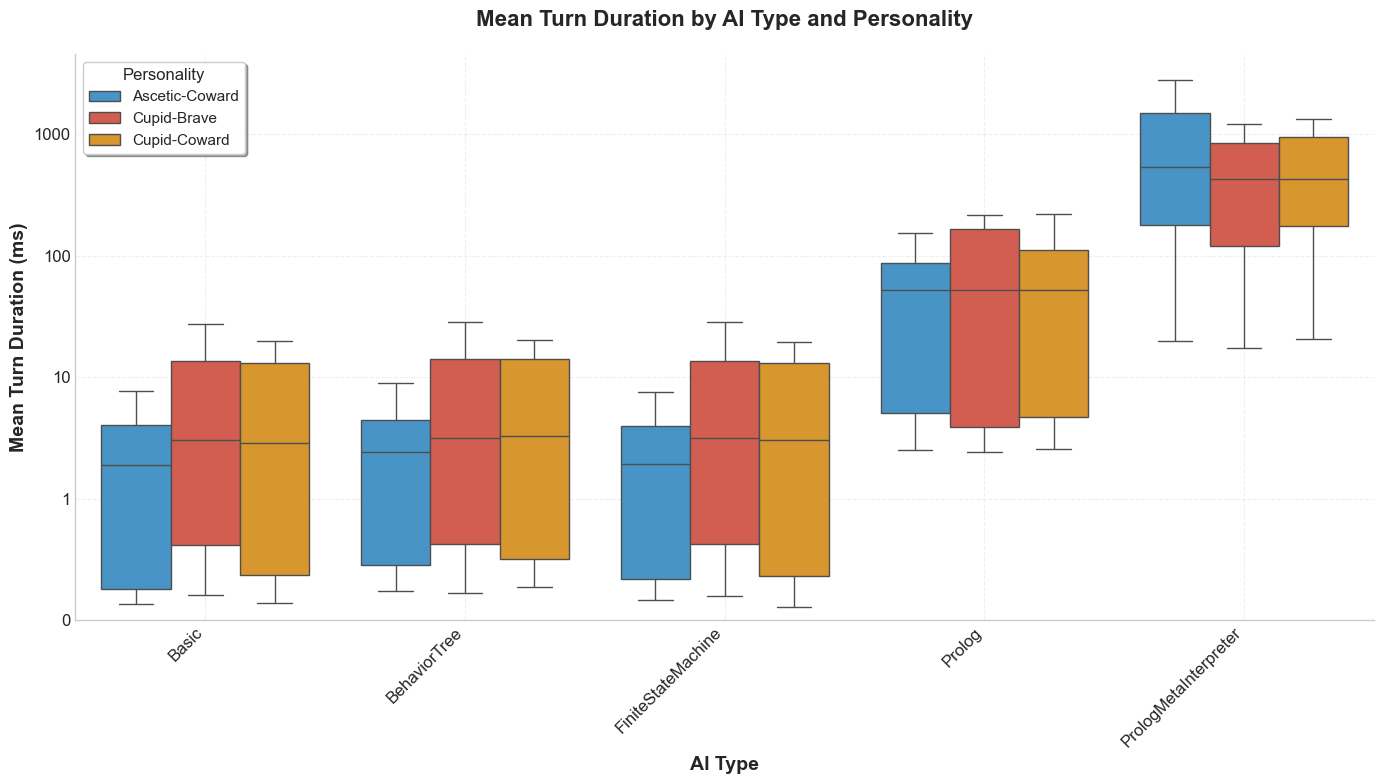

In [9]:
plt.figure(figsize=(14, 8))
ax = sns.boxplot(x="ai_type", y="mean_turn", hue="personality", data=df, 
                 showfliers=False, palette=personality_colors)
plt.title("Mean Turn Duration by AI Type and Personality", 
          fontweight='bold', pad=20)
plt.yscale("log")
plt.xlabel("AI Type", fontweight='bold')
plt.ylabel("Mean Turn Duration (ms)", fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Customize legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Personality', title_fontsize=12, 
          loc='upper left', frameon=True, fancybox=True, shadow=True)

# Format y-axis to show actual values on log scale
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_ylim(bottom=0.1)

# Add grid
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('./figures/ai_type_personality_mean_turn.pdf', dpi=300, bbox_inches='tight')
plt.show()


## 10. Total Execution Time by AI Type and Personality

This bar chart examines how personality traits affect total execution time across different AI implementations. The analysis reveals the combined impact of computational overhead and exploration efficiency:

**Key Observations:**
- **Personality-driven efficiency**: Brave personalities typically show faster total execution times due to more direct exploration paths
- **Coward penalty**: Coward personalities require longer total execution times due to cautious exploration patterns requiring more steps
- **AI type consistency**: The relative performance hierarchy between AI types remains consistent across all personality combinations
- **Compound effects**: Total execution time reflects both per-turn computational cost and the number of turns required based on personality-driven behavior
- **Scalability patterns**: Logic-based AIs show more pronounced increases in execution time, especially when combined with cautious personality traits


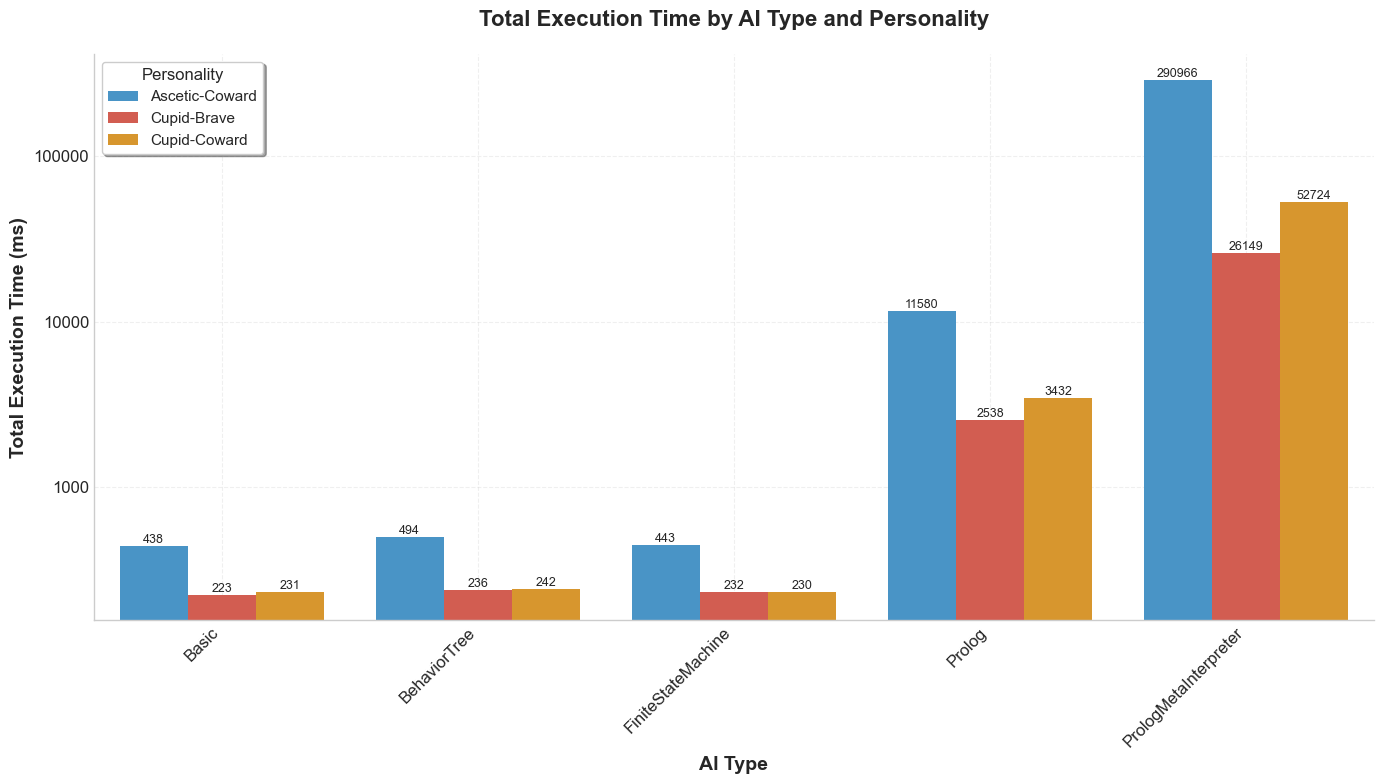

In [10]:
plt.figure(figsize=(14, 8))
ax = sns.barplot(x="ai_type", y="total_time", hue="personality", data=df, 
                 errorbar=None, palette=personality_colors)
plt.title("Total Execution Time by AI Type and Personality", 
          fontweight='bold', pad=20)
plt.yscale("log")
plt.xlabel("AI Type", fontweight='bold')
plt.ylabel("Total Execution Time (ms)", fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Customize legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Personality', title_fontsize=12, 
          loc='upper left', frameon=True, fancybox=True, shadow=True)

# Format y-axis to show actual values on log scale
ax.yaxis.set_major_formatter(ScalarFormatter())

# Add grid
ax.grid(True, alpha=0.3, linestyle='--')

# Add value labels on bars for better readability
for container in ax.containers:
    ax.bar_label(container, fmt="%.0f", fontsize=9)

plt.tight_layout()
plt.savefig('./figures/ai_type_personality_total_time.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 11. Performance Metrics Summary Tables

The following summary tables provide comprehensive performance metrics across different dimensions of the analysis:

In [11]:
print("Summary of Performance Metrics by AI Type:")
ai_summary = (
    df.groupby("ai_type")
    .agg(
        {
            "mean_turn":   "mean",
            "median_turn": "mean",
            "total_time":  "mean",
            "steps":       "mean",
        }
    )
    .reset_index()
)
ai_summary = ai_summary.rename(
    columns={
        "ai_type": "AI Type",
        "mean_turn": "Mean Turn Duration (ms)",
        "median_turn": "Median Turn Duration (ms)",
        "total_time": "Mean Execution Time (ms)",
        "steps": "Mean Steps",
    }
)
print(ai_summary.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

print("\nSummary for Mean Turn Duration by Grid Size:")
mean_grid_summary = df.groupby("num_cells").agg({"mean_turn": "mean"}).reset_index()

# Add mean turn time (in ms) for each AI type
mean_time_by_ai = df.pivot_table(
    index="num_cells", columns="ai_type", values="mean_turn", aggfunc="mean"
).reset_index()

mean_grid_summary = mean_grid_summary.merge(mean_time_by_ai, on="num_cells")

# Move overall mean_time to be the last column
cols = [c for c in mean_grid_summary.columns if c != "mean_turn"] + ["mean_turn"]
mean_grid_summary = mean_grid_summary[cols]

mean_grid_summary = mean_grid_summary.rename(
    columns={
        "num_cells": "Grid Size",
        "mean_turn": "Mean Turn Duration (ms)",
    }
)
print(mean_grid_summary.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

print("\nSummary for Mean Execution Time by Grid Size:")
total_grid_summary = (
    df.groupby("num_cells")
    .agg(
        {
            "steps":     "mean",
            "total_time": "mean",
        }
    )
    .reset_index()
)

# Add total execution time (in ms) for each AI type
total_time_by_ai = df.pivot_table(
    index="num_cells", columns="ai_type", values="total_time", aggfunc="mean"
).reset_index()

total_grid_summary = total_grid_summary.merge(total_time_by_ai, on="num_cells")

# Move overall total_time to be the last column
cols = [c for c in total_grid_summary.columns if c != "total_time"] + ["total_time"]
total_grid_summary = total_grid_summary[cols]

total_grid_summary = total_grid_summary.rename(
    columns={
        "num_cells": "Grid Size",
        "steps": "Mean Steps",
        "total_time": "Mean Execution Time (ms)",
    }
)
print(total_grid_summary.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

print("\nSummary for Steps by Grid Size:")
steps_grid_summary = df.groupby("num_cells").agg({"steps": "mean"}).reset_index()

# Add steps (mean) for each AI type
steps_by_ai_grid = df.pivot_table(
    index="num_cells", columns="ai_type", values="steps", aggfunc="mean"
).reset_index()

steps_grid_summary = steps_grid_summary.merge(steps_by_ai_grid, on="num_cells")

# Move overall mean_steps to be the last column. The column is named 'steps'.
cols = [c for c in steps_grid_summary.columns if c != "steps"] + ["steps"]
steps_grid_summary = steps_grid_summary[cols]

steps_grid_summary = steps_grid_summary.rename(
    columns={
        "num_cells": "Grid Size",
        "steps": "Mean Steps",
    }
)
print(steps_grid_summary.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

print("\nSummary by Number of Agents:")
agent_summary = (
    df.groupby("num_agents")
    .agg(
        {
            "mean_turn": "mean",
            "total_time": "mean",
            "steps": "mean",
        }
    )
    .reset_index()
)

agent_summary = agent_summary.rename(
    columns={
        "num_agents": "Number of Agents",
        "mean_turn": "Mean Turn Duration (ms)",
        "total_time": "Mean Execution Time (ms)",
        "steps": "Mean Steps",
    }
)
print(agent_summary.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

print("\nSummary by Personality:")
personality_summary = (
    df.groupby("personality")
    .agg(
        {
            "mean_turn": "mean",
            "total_time": "mean",
            "steps": "mean",
        }
    )
    .reset_index()
)


personality_summary = personality_summary.rename(
    columns={
        "personality": "Personality",
        "mean_turn": "Mean Turn Duration (ms)",
        "total_time": "Mean Execution Time (ms)",
        "steps": "Mean Steps",
    }
)
print(personality_summary.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

print("\nSummary for Mean Turn Duration by Number of Agents:")
mean_agent_summary = df.groupby("num_agents").agg({"mean_turn": "mean"}).reset_index()

# Add mean turn time (in ms) for each AI type
mean_turn_by_ai_agents = df.pivot_table(
    index="num_agents", columns="ai_type", values="mean_turn", aggfunc="mean"
).reset_index()

mean_agent_summary = mean_agent_summary.merge(mean_turn_by_ai_agents, on="num_agents")

# Move overall mean_turn to be the last column
cols = [c for c in mean_agent_summary.columns if c != "mean_turn"] + ["mean_turn"]
mean_agent_summary = mean_agent_summary[cols]

mean_agent_summary = mean_agent_summary.rename(
    columns={
        "num_agents": "Number of Agents",
        "mean_turn": "Mean Turn Duration (ms)",
    }
)
print(mean_agent_summary.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

print("\nSummary for Mean Total Execution Time by Number of Agents:")
total_agent_summary = (
    df.groupby("num_agents")
    .agg(
        {
            "steps":     "mean",
            "total_time": "mean",
        }
    )
    .reset_index()
)

# Add total execution time (in ms) for each AI type
total_time_by_ai_agents = df.pivot_table(
    index="num_agents", columns="ai_type", values="total_time", aggfunc="mean"
).reset_index()

total_agent_summary = total_agent_summary.merge(total_time_by_ai_agents, on="num_agents")

# Move overall total_time to be the last column
cols = [c for c in total_agent_summary.columns if c != "total_time"] + ["total_time"]
total_agent_summary = total_agent_summary[cols]

total_agent_summary = total_agent_summary.rename(
    columns={
        "num_agents": "Number of Agents",
        "steps": "Mean Steps",
        "total_time": "Mean Total Execution Time (ms)",
    }
)
print(total_agent_summary.to_string(index=False, float_format=lambda x: f"{x:.2f}"))


print("\nSummary for Mean Turn Duration by Personality:")
mean_personality_summary = (
    df.groupby("personality").agg({"mean_turn": "mean"}).reset_index()
)

# Add mean turn time (in ms) for each AI type
mean_turn_by_ai_personality = df.pivot_table(
    index="personality", columns="ai_type", values="mean_turn", aggfunc="mean"
).reset_index()

mean_personality_summary = mean_personality_summary.merge(
    mean_turn_by_ai_personality, on="personality"
)

# Move overall mean_turn to be the last column
cols = [c for c in mean_personality_summary.columns if c != "mean_turn"] + ["mean_turn"]
mean_personality_summary = mean_personality_summary[cols]

mean_personality_summary = mean_personality_summary.rename(
    columns={
        "personality": "Personality",
        "mean_turn": "Mean Turn Duration (ms)",
    }
)
print(
    mean_personality_summary.to_string(index=False, float_format=lambda x: f"{x:.2f}")
)


print("\nSummary for Mean Total Execution Time by Personality:")
total_personality_summary = (
    df.groupby("personality")
    .agg(
        {
            "total_time": "mean",
        }
    )
    .reset_index()
)

# Add total execution time (in ms) for each AI type
total_time_by_ai_personality = df.pivot_table(
    index="personality", columns="ai_type", values="total_time", aggfunc="mean"
).reset_index()

total_personality_summary = total_personality_summary.merge(
    total_time_by_ai_personality, on="personality"
)

# Move overall total_time to be the last column
cols = [c for c in total_personality_summary.columns if c != "total_time"] + [
    "total_time"
]
total_personality_summary = total_personality_summary[cols]

total_personality_summary = total_personality_summary.rename(
    columns={
        "personality": "Personality",
        "total_time": "Mean Total Execution Time (ms)",
    }
)
print(
    total_personality_summary.to_string(index=False, float_format=lambda x: f"{x:.2f}")
)


print("\nSummary for Steps by Personality:")
steps_personality_summary = (
    df.groupby("personality")
    .agg(
        {
            "steps": "mean",
        }
    )
    .reset_index()
)

# Add steps for each AI type
steps_by_ai_personality = df.pivot_table(
    index="personality", columns="ai_type", values="steps", aggfunc="mean"
).reset_index()

steps_personality_summary = steps_personality_summary.merge(
    steps_by_ai_personality, on="personality"
)

# Move overall steps to be the last column
cols = [c for c in steps_personality_summary.columns if c != "steps"] + ["steps"]
steps_personality_summary = steps_personality_summary[cols]

steps_personality_summary = steps_personality_summary.rename(
    columns={
        "personality": "Personality",
        "steps": "Mean Steps",
    }
)
print(
    steps_personality_summary.to_string(index=False, float_format=lambda x: f"{x:.2f}")
)

Summary of Performance Metrics by AI Type:
              AI Type  Mean Turn Duration (ms)  Median Turn Duration (ms)  Mean Execution Time (ms)  Mean Steps
                Basic                     7.46                       2.59                    297.27      524.92
         BehaviorTree                     8.04                       2.73                    323.96      524.92
   FiniteStateMachine                     7.59                       2.53                    301.57      524.92
               Prolog                    75.64                      74.56                   5850.15      524.92
PrologMetaInterpreter                   768.52                     823.26                 123279.69      524.92

Summary for Mean Turn Duration by Grid Size:
 Grid Size  Basic  BehaviorTree  FiniteStateMachine  Prolog  PrologMetaInterpreter  Mean Turn Duration (ms)
       100   4.38          5.70                4.42   55.59                 292.00                    72.42
       225   2.66      

## 12. Comprehensive Performance Analysis Results

Our analysis of agent performance in the Wumpus World environment, incorporating all available files, reveals refined insights into the performance of different AI implementations.

 **Important Note**: For multi-agent scenarios (5 or 10 agents), all metrics (steps, turn duration, execution time) are multiplied by the number of agents to represent total computational cost and work performed by all agents combined. Below are the key findings:

#### AI Type Performance Comparison

1.  **Computational Efficiency (Mean Turn Duration)**
    *   Basic: 7.46 ms/turn
    *   FiniteStateMachine: 7.59 ms/turn
    *   BehaviorTree: 8.04 ms/turn
    *   Prolog: 75.64 ms/turn (≈+915% slower than Basic/FSM/BT)
    *   PrologMetaInterpreter: 768.52 ms/turn (≈+9,800% slower than Basic/FSM/BT)

2.  **Median Turn Duration**
    *   Basic: 2.59 ms
    *   FSM: 2.53 ms
    *   BT: 2.73 ms
    *   Prolog: 74.56 ms (≈+2,800% slower than Basic/FSM/BT)
    *   Meta‐Interpreter: 823.26 ms (≈+31,600% slower than Basic/FSM/BT)

3.  **Total Processing Time (Mean Execution Time)**
    *   Basic: 297.27 ms
    *   FSM: 301.57 ms
    *   BT: 323.96 ms
    *   Prolog: 5,850.15 ms (≈+1,860% slower than Basic/FSM/BT)
    *   Meta‐Interpreter: 123,279.69 ms (≈+38,400% slower than Basic/FSM/BT)

4.  **Exploration Behavior (Mean Steps)**
    *   All AI types traverse ~524.92 steps on average, confirming identical exploration logic across implementations.

#### Grid Size Impact

1.  **Mean Steps by AI Type and Grid Size**

| AI Type | 100 cells | 225 cells \[2.25× vs. prev] (+% vs. prev) | 400 cells \[1.78× vs. prev] (+% vs. prev) | 625 cells \[1.56× vs. prev] (+% vs. prev) | (+% 100 → 625) |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **Basic AI** | 179.22 | 538.56 (**+200%**) | 570.67 (**+6%**) | 811.22 (**+42%**) | **+353%** |
| **BehaviorTree** | 179.22 | 538.56 (**+200%**) | 570.67 (**+6%**) | 811.22 (**+42%**) | **+353%** |
| **FiniteStateMachine** | 179.22 | 538.56 (**+200%**) | 570.67 (**+6%**) | 811.22 (**+42%**) | **+353%** |
| **Prolog** | 179.22 | 538.56 (**+200%**) | 570.67 (**+6%**) | 811.22 (**+42%**) | **+353%** |
| **PrologMetaInterpreter** | 179.22 | 538.56 (**+200%**) | 570.67 (**+6%**) | 811.22 (**+42%**) | **+353%** |
| **Mean Steps** | 179.22 | 538.56 (**+200%**) | 570.67 (**+6%**) | 811.22 (**+42%**) | **+353%** |

*   All AI types traverse a nearly identical number of steps for each grid size, confirming uniform exploration logic.
*   The number of steps scales with grid size, showing the largest increase (+200%) from 100 to 225 cells, followed by smaller increases (+6% and +42% for subsequent transitions).
*   Overall, the step count increases by +353% from the smallest (100 cells) to largest (625 cells) grid size.

2.  **Mean Turn Duration by AI Type and Grid Size**

| AI Type | 100 cells | 225 cells \[2.25× vs. prev] (+% vs. prev) | 400 cells \[1.78× vs. prev] (+% vs. prev) | 625 cells \[1.56× vs. prev] (+% vs. prev) | (+% 100 → 625) |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **Basic AI** | 4.38 | 2.66 (**−39%**) | 9.28 (**+249%**) | 13.52 (**+46%**) | **+209%** |
| **FSM** | 4.42 | 2.73 (**−38%**) | 9.25 (**+239%**) | 13.95 (**+51%**) | **+216%** |
| **BT** | 5.70 | 2.84 (**−50%**) | 9.29 (**+227%**) | 14.31 (**+54%**) | **+151%** |
| **Prolog** | 55.59 | 58.53 (**+5%**) | 89.02 (**+52%**) | 99.43 (**+12%**) | **+79%** |
| **PrologMetaInterpreter** | 292.00 | 583.35 (**+100%**) | 938.03 (**+61%**) | 1260.70 (**+34%**) | **+332%** |
| **Mean Turn Duration** | 72.42 | 130.02 (**+80%**) | 210.98 (**+62%**) | 280.38 (**+33%**) | **+287%** |

*   **Basic, FSM, and BT** show an initial decrease (-38% to -50%) from 100 to 225 cells, then significant increases (+227% to +249%) from 225 to 400 cells, followed by more moderate increases (+46% to +54%) from 400 to 625 cells.
*   **Prolog** demonstrates steady increases across all transitions: +5% (100→225), +52% (225→400), and +12% (400→625), with an overall increase of +79%.
*   **PrologMetaInterpreter** shows the largest increases: +100% (100→225), +61% (225→400), and +34% (400→625), with an overall increase of +332%.
*   The performance gap between procedural AIs (Basic/FSM/BT) and logic-based AIs (Prolog/Meta-Interpreter) widens significantly as grid size increases.

3.  **Mean Total Execution Time by AI Type and Grid Size**

| AI Type | 100 cells | 225 cells \[2.25× vs. prev] (+% vs. prev) | 400 cells \[1.78× vs. prev] (+% vs. prev) | 625 cells \[1.56× vs. prev] (+% vs. prev) | (+% 100 vs. 625) |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **Basic AI** | 79.69 | 211.79 (**+166%**) | 391.60 (**+85%**) | 506.00 (**+29%**) | **+535%** |
| **FSM** | 79.50 | 217.73 (**+174%**) | 400.46 (**+84%**) | 508.59 (**+27%**) | **+540%** |
| **BT** | 127.30 | 220.84 (**+73%**) | 400.68 (**+81%**) | 547.03 (**+37%**) | **+330%** |
| **Prolog** | 1,246.71 | 5,040.71 (**+304%**) | 6,926.00 (**+37%**) | 10,187.18 (**+47%**) | **+717%** |
| **PrologMetaInterpreter** | 7,575.13 | 58,434.46 (**+672%**) | 117,618.17 (**+101%**) | 309,491.01 (**+163%**) | **+3,987%** |
| **Mean Execution Time** | 1,821.67 | 12,825.11 (**+604%**) | 25,147.38 (**+96%**) | 64,247.96 (**+155%**) | **+3,427%** |

*   **Basic and FSM** show similar scaling patterns: large increases from 100→225 cells (+166% to +174%), moderate increases from 225→400 cells (+84% to +85%), and smaller increases from 400→625 cells (+27% to +29%), with overall increases of +535% to +540%.
*   **BehaviorTree** demonstrates more gradual scaling: +73% (100→225), +81% (225→400), and +37% (400→625), with an overall increase of +330%.
*   **Prolog** shows the most dramatic initial increase (+304% from 100→225), then more moderate increases (+37% and +47%), with an overall increase of +717%.
*   **PrologMetaInterpreter** exhibits extreme scaling: +672% (100→225), +101% (225→400), and +163% (400→625), with a massive overall increase of +3,987%.
*   The performance disparity between AI types becomes increasingly pronounced with larger grid sizes, particularly for the Meta-Interpreter implementation.

4.  **Scaling Insights**
    *   Larger grids amplify both per‐turn decision overhead and path length.
    *   Total time grows super‐linearly: tile count drives path length, while search/planning cost per turn also increases.
    *   Logic-based AIs (Prolog, Meta-Interpreter) are disproportionately affected by grid size, highlighting scalability limitations compared to procedural approaches.

#### Agent Number Impact

1.  **Total Computational Cost Scaling**
    *   Total computational turn duration (all agents combined) grows with agent count:
        *   1 agent: 20.64 ms (individual agent cost)
        *   5 agents: 144.06 ms (+598% vs. 1 agent)
        *   10 agents: 355.64 ms (+147% vs. 5 agents, +1,623% vs. 1 agent)
    *   Multiple agents increase total system computational load, but individual agent efficiency improves in multi-agent scenarios.

2.  **Total Steps by AI Type and Number of Agents**

| AI Type | 1 Agent | 5 Agents (+% vs. prev) | 10 Agents (+% vs. prev) | (% 1 vs 10) |
| :--- | :--- | :--- | :--- | :--- |
| **Basic AI** | 404.75 | 567.50 (**+40%**) | 602.50 (**+6%**) | **+49%** |
| **FSM** | 404.75 | 567.50 (**+40%**) | 602.50 (**+6%**) | **+49%** |
| **BT** | 404.75 | 567.50 (**+40%**) | 602.50 (**+6%**) | **+49%** |
| **Prolog** | 404.75 | 567.50 (**+40%**) | 602.50 (**+6%**) | **+49%** |
| **PrologMetaInterpreter** | 404.75 | 567.50 (**+40%**) | 602.50 (**+6%**) | **+49%** |
| **Mean Steps** | **404.75** | **567.50** (**+40%**) | **602.50** (**+6%**) | **+49%** |

*   All AI types show identical step patterns across agent counts, confirming uniform exploration logic.
*   Total steps increase by +40% from 1 to 5 agents, then by +6% from 5 to 10 agents, with an overall increase of +49% from 1 to 10 agents.
*   The total system step count increases with agent count, representing cumulative work performed by all agents.

3.  **Total Turn Duration by AI Type and Number of Agents (Cumulative)**

| AI Type | 1 Agent | 5 Agents (ms) (+% vs. prev) | 10 Agents (ms) (+% vs. prev) |  (% 1 vs 10) |
| :--- | :--- | :--- | :--- | :--- |
| **Basic AI** | 0.20 | 4.62 (**+2,210%**) | 17.55 (**+280%**) | **+8,675%** |
| **FSM** | 0.21 | 4.67 (**+2,124%**) | 17.89 (**+283%**) | **+8,424%** |
| **BT** | 0.25 | 5.14 (**+1,956%**) | 18.72 (**+264%**) | **+7,388%** |
| **Prolog** | 3.48 | 51.56 (**+1,382%**) | 171.89 (**+233%**) | **+4,840%** |
| **PrologMetaInterpreter** | 99.09 | 654.32 (**+560%**) | 1552.15 (**+137%**) | **+1,466%** |
| **Mean Turn Duration** | 20.64 | 144.06 (**+598%**) | 355.64 (**+147%**) | **+1,623%** |

*   **Procedural AIs (Basic/FSM/BT)** show massive increases from 1 to 5 agents (+1,956% to +2,210%), followed by substantial increases from 5 to 10 agents (+264% to +283%), with overall increases of +7,388% to +8,675%.
*   **Prolog** demonstrates a large increase from 1 to 5 agents (+1,382%), then a significant increase from 5 to 10 agents (+233%), with an overall increase of +4,840%.
*   **PrologMetaInterpreter** shows more moderate scaling: +560% (1→5 agents) and +137% (5→10 agents), with an overall increase of +1,466%.
*   Total computational cost scales approximately linearly with agent count, but individual agent efficiency improves in multi-agent scenarios.

4.  **Total System Execution Time (Cumulative)**
    *   Total computational work increases with more agents:
        *   1 agent: 14,822.29 ms (individual cost)
        *   5 agents: 28,300.14 ms (+91% vs. 1 agent)
        *   10 agents: 34,909.16 ms (+23% vs. 5 agents, +136% vs. 1 agent)
    *   More agents require more total computational resources but complete tasks faster individually.

5.  **Total Execution Time by AI Type and Number of Agents (Cumulative)**

| AI Type | 1 Agent | 5 Agents (ms) (+% vs. prev) | 10 Agents (ms) (+% vs. prev) |  (% 1 vs 10) |
| :--- | :--- | :--- | :--- | :--- |
| **Basic AI** | 76.31 | 307.56 (**+303%**) | 507.93 (**+65%**) | **+565%** |
| **FSM** | 79.95 | 313.58 (**+292%**) | 511.18 (**+63%**) | **+539%** |
| **BT** | 84.00 | 360.67 (**+329%**) | 527.22 (**+46%**) | **+528%** |
| **Prolog** | 1,746.09 | 6,230.17 (**+257%**) | 9,574.20 (**+54%**) | **+448%** |
| **PrologMetaInterpreter** | 72,125.11 | 134,288.71 (**+86%**) | 163,425.26 (**+22%**) | **+127%** |
| **Mean Total Execution Time** | 14,822.29 | 28,300.14 (**+91%**) | 34,909.16 (**+23%**) | **+136%** |

*   **Procedural AIs (Basic/FSM/BT)** show substantial increases from 1 to 5 agents (+292% to +329%), followed by moderate increases from 5 to 10 agents (+46% to +65%), with overall increases of +528% to +565%.
*   **Prolog** demonstrates a large increase from 1 to 5 agents (+257%), then a moderate increase from 5 to 10 agents (+54%), with an overall increase of +448%.
*   **PrologMetaInterpreter** shows more conservative scaling: +86% (1→5 agents) and +22% (5→10 agents), with an overall increase of +127%.
*   Total computational resources scale with agent count, but efficiency gains per agent reduce the per-agent computational cost in multi-agent scenarios.

6.  **Multi-Agent Resource Insights**
    *   **Resource vs. Speed Trade-off**: More agents require more total computational resources but achieve faster task completion
    *   **Efficiency gains**: Individual agents become more efficient when working in teams, but total system cost increases
    *   **Scalability patterns**: Different AI types show varying efficiency gains, with logic-based AIs showing different scaling characteristics compared to procedural AIs

#### Personality Influence

1.  **Mean Steps by AI Type and Personality**

| AI Type | Cupid-Brave | Cupid-Coward (+% vs. prev) | Ascetic-Coward (+% vs. prev) | (% Cupid-Brave vs Ascetic-Coward) |
| :--- | :--- | :--- | :--- | :--- |
| **Basic AI** | 237.58 | 379.00 (**+60%**) | 958.17 (**+153%**) | **+303%** |
| **FSM** | 237.58 | 379.00 (**+60%**) | 958.17 (**+153%**) | **+303%** |
| **BT** | 237.58 | 379.00 (**+60%**) | 958.17 (**+153%**) | **+303%** |
| **Prolog** | 237.58 | 379.00 (**+60%**) | 958.17 (**+153%**) | **+303%** |
| **PrologMetaInterpreter** | 237.58 | 379.00 (**+60%**) | 958.17 (**+153%**) | **+303%** |
| **Mean Steps** | 237.58 | 379.00 (**+60%**) | 958.17 (**+153%**) | **+303%** |

*   All AI types show identical step patterns across personalities, confirming uniform exploration logic implementation.
*   Steps increase by +60% from Cupid-Brave to Cupid-Coward, then by +153% from Cupid-Coward to Ascetic-Coward.
*   Overall, Ascetic-Coward agents take +303% more steps than Cupid-Brave agents.
 
2.  **Mean Turn Duration by AI Type and Personality**
 
| AI Type | Cupid-Brave (ms) | Cupid-Coward (ms) (+% vs. prev) | Ascetic-Coward (ms) (+% vs. prev) | (% Cupid-Brave vs Ascetic-Coward) |
| :--- | :--- | :--- | :--- | :--- |
| **Basic AI** | 11.66 | 8.17 (**-30%**) | 2.55 (**-69%**) | **-78%** |
| **FSM** | 12.28 | 7.94 (**-35%**) | 2.55 (**-68%**) | **-79%** |
| **BT** | 12.49 | 8.42 (**-33%**) | 3.19 (**-62%**) | **-74%** |
| **Prolog** | 83.01 | 81.01 (**-2%**) | 62.90 (**-22%**) | **-24%** |
| **PrologMetaInterpreter** | 521.71 | 575.25 (**+10%**) | 1208.60 (**+110%**) | **+132%** |
| **Mean Turn Duration** | 128.23 | 136.16 (**+6%**) | 255.96 (**+88%**) | **+100%** |

*   **Procedural AIs (Basic/FSM/BT)** show decreasing turn durations from Cupid-Brave to Cupid-Coward (-30% to -35%), and further decreases to Ascetic-Coward (-62% to -69%), with overall decreases of -74% to -79%.
*   **Prolog** demonstrates small decreases: -2% (Cupid-Brave→Cupid-Coward) and -22% (Cupid-Coward→Ascetic-Coward), with an overall decrease of -24%.
*   **PrologMetaInterpreter** shows increasing turn durations: +10% (Cupid-Brave→Cupid-Coward) and +110% (Cupid-Coward→Ascetic-Coward), with an overall increase of +132%.
*   Mean turn duration increases by +6% from Cupid-Brave to Cupid-Coward, then by +88% to Ascetic-Coward, for an overall increase of +100%.
 
3.  **Mean Total Execution Time by AI Type and Personality**
 
| AI Type | Cupid-Brave (ms) | Cupid-Coward (ms) (+% vs. prev) | Ascetic-Coward (ms) (+% vs. prev) | (% Cupid-Brave vs Ascetic-Coward) |
| :--- | :--- | :--- | :--- | :--- |
| **Basic AI** | 222.82 | 231.20 (**+4%**) | 437.79 (**+89%**) | **+96%** |
| **FSM** | 231.85 | 229.84 (**-1%**) | 443.02 (**+93%**) | **+91%** |
| **BT** | 236.08 | 241.61 (**+2%**) | 494.20 (**+105%**) | **+109%** |
| **Prolog** | 2,538.11 | 3,432.23 (**+35%**) | 11,580.12 (**+237%**) | **+356%** |
| **PrologMetaInterpreter** | 26,149.20 | 52,723.80 (**+102%**) | 290,966.09 (**+452%**) | **+1,013%** |
| **Mean Total Execution Time** | 5,875.61 | 11,371.73 (**+94%**) | 60,784.24 (**+435%**) | **+935%** |

*   **Procedural AIs (Basic/FSM/BT)** show small changes from Cupid-Brave to Cupid-Coward (-1% to +4%), then substantial increases to Ascetic-Coward (+89% to +105%), with overall increases of +91% to +109%.
*   **Prolog** demonstrates moderate increases: +35% (Cupid-Brave→Cupid-Coward) and +237% (Cupid-Coward→Ascetic-Coward), with an overall increase of +356%.
*   **PrologMetaInterpreter** shows dramatic increases: +102% (Cupid-Brave→Cupid-Coward) and +452% (Cupid-Coward→Ascetic-Coward), with a massive overall increase of +1,013%.
*   Mean total execution time increases by +94% from Cupid-Brave to Cupid-Coward, then by +435% to Ascetic-Coward, for an overall increase of +935%.

4.  **Personality Insights**
    *   **Cupid-Brave agents** are the most efficient, willing to confront the Wumpus and collect gold to minimize exploration (237.58 steps).
    *   **Cupid-Coward agents** are moderately efficient, collecting gold but avoiding the Wumpus, leading to +60% more steps (379.00 steps).
    *   **Ascetic-Coward agents** are the least efficient, avoiding both the Wumpus and gold, resulting in +303% more steps than Cupid-Brave (958.17 steps).
    *   Logic-based AIs (especially PrologMetaInterpreter) show dramatic performance degradation with less aggressive personalities, while procedural AIs maintain better relative performance across personality types.

These findings highlight the trade-offs between computational efficiency and exploration behavior, with grid size, agent number, and personality traits significantly influencing performance metrics across different AI implementation approaches.